In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(seed=42) 

In [2]:
raw_info = pd.read_csv(f"IBIS_V06_CSF_All.csv", usecols=[
    "CandID","Age_at_visit_start","Project","Status","ASD_DX",
    "ASD_DX_group","group ID","Identifiers","Cohort","Risk"])
raw_info.head()

,CandID,Age_at_visit_start,Project,Status,ASD_DX,ASD_DX_group,group ID,Identifiers,Cohort,Risk
0,103430,25.0,IBIS1,Complete,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,STL0188,6 month recruit,HR
1,107524,25.0,IBIS1,Complete,YES (DSM_IV questions 4a/4b is Yes),ASD,2,STL0200,6 month recruit,HR
2,108372,24.0,IBIS2,Active,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,UNC1023,IBIS2 Low Risk,LR
3,113320,24.0,IBIS1,Active,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,PHI0207,Control,LR
4,114640,26.0,IBIS1,Active,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,SEA0102,Control,LR


In [3]:
raw_info[["ASD_DX_group", "Risk"]].value_counts()

ASD_DX_group     Risk
TYPICAL          HR      149
                 LR       99
ASD              HR       39
ATYPICAL_ADOS    HR       17
ATYPICAL_MULLEN  HR        9
ATYPICAL_ADOS    LR        7
ASD              LR        3
ATYPICAL_MULLEN  LR        2
dtype: int64

In [4]:
inliers = raw_info.query("ASD_DX_group=='TYPICAL' & Risk=='LR'")["CandID"]
inliers.shape

(99,)

In [41]:
outliers = raw_info.query("ASD_DX_group !='TYPICAL' & Risk=='HR'")["CandID"]
outliers.shape

(65,)

## TODO: Save selected subject IDs

> **INTERSECT WITH SUBJECTS THAT WE ACTUALLY HAVE ON DISK!!!**

In [5]:
import glob,os
R = re.compile(r"stx_(\d*)_VSA_*")

t1_paths = glob.glob("/ASD/Autism/IBIS/Proc_Data/*/VSA/mri/registered_stx/sMRI/*T1w.nrrd")
t2_paths = glob.glob("/ASD/Autism/IBIS/Proc_Data/*/VSA/mri/registered_stx/sMRI/*T2w.nrrd")

In [29]:
import ants

t1_img = ants.image_read(t1_paths[0])
t1_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-196.0, -232.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

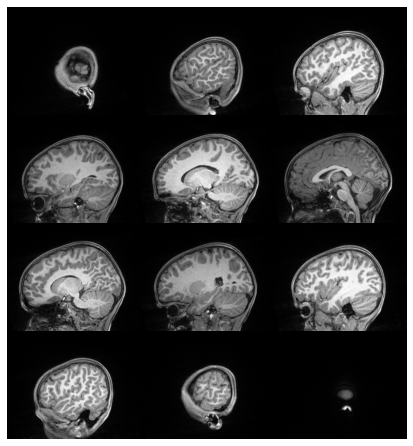

In [30]:
t1_img.plot()

In [13]:
fname = "/BEE/Connectome/ABCD/Users/amahmood/braintyp/ibis/108131.nii.gz"
img = ants.image_read(fname)
img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 2
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-188.0, -224.0, 4.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [23]:
t1img = ants.from_numpy(img.numpy()[...,1])
t1img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

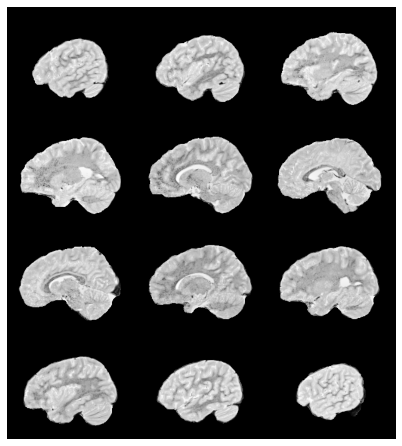

In [24]:
t1img.plot()

In [32]:
_fn = lambda x: R.search(x).group(1)
t1_ids = set(map(_fn, t1_paths))
t2_ids = set(map(_fn, t2_paths))
subject_ids = t1_ids.intersection(t2_ids)

In [33]:
len(t1_ids), len(t2_ids), len(subject_ids)

(206, 205, 205)

In [37]:
on_disk = inliers.isin(subject_ids)
on_disk

2      False
3      False
4       True
6       True
11     False
       ...  
315    False
318    False
323    False
325     True
335    False
Name: CandID, Length: 99, dtype: bool

In [47]:
inlier_keys = inliers[on_disk]
inlier_keys.shape

(43,)

In [46]:
outlier_keys = outliers[outliers.isin(subject_ids)]
outlier_keys.shape

(24,)

In [48]:
# inlier_keys.to_csv("ibis_inlier_keys.txt", header=None, index=None)
# outlier_keys.to_csv("ibis_outlier_keys.txt", header=None, index=None)